In [9]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [1]:
#region-layer mask, download from https://db.cngb.org/stomics/mbcsta/download/
manual_label <- read.csv('data/bin50_layer_region_manual_0613.csv.gz')
rownames(manual_label) <- paste0(manual_label$sample,'_',manual_label$x,'_',manual_label$y)

In [7]:
#Coronal transform matrix, download from https://db.cngb.org/stomics/mbcsta/download/
matrix_list <- read.table("data/transform.txt",header=1)

In [142]:
#load function
source('R_function/segment2flatmap.R')
source('R_function/knn_function.R')

In [8]:
#Preprocessing main part of segment
segment_list <- lapply(unique(manual_label[,'sample']),function(slice){
    #download from https://db.cngb.org/stomics/mbcsta/download/
    file_path <- paste0('data/bin50_segment_mask/',slice,'.txt')
    if(!(file.exists(file_path))){
        NULL
    }else{
    segment <- read.csv(file_path,sep='\t')
    #Registration slice by transform matrix
    coor_t <- trakem_transform(segment$x,segment$y,matrix_list[matrix_list$title==slice,]$matrix,50,50)
    segment$slice <- slice
    segment$x_registration <- coor_t$rx
    segment$y_registration <- coor_t$ry
    segment$pole <- 'No'
    #Merge 10 adjacent segments
    segment$segment <- as.integer(segment$region/10)
    #Merge paxinos region label to segment mask
    segment$label <- paste0(slice,'_',segment$x,'_',segment$y)
    rownames(segment) <- segment$label
    segment$id <- paste0(slice,'_segment_',segment$segment)
    tmp_region <- manual_label[manual_label$sample==slice,]
    segment$region <- tmp_region[segment$label,'region']   
    return(segment)}
    })
segment <- bind_rows(segment_list)

ERROR: Error in bind_rows(segment_list): could not find function "bind_rows"


In [11]:
#Preprocessing temporal pole part of segment
segment_list_t <- lapply(c('T437','T438','T439'),function(slice){
    #download from https://db.cngb.org/stomics/mbcsta/download/
    file_path <- paste0('data/bin50_segment_mask/',slice,'_t.txt')
    if(!(file.exists(file_path))){
        NULL
    }else{
    segment <- read.csv(file_path,sep='\t')
    #Registration slice by transform matrix
    coor_t <- trakem_transform(segment$x,segment$y,matrix_list[matrix_list$title==slice,]$matrix,50,50)
    segment$slice <- slice
    segment$x_registration <- coor_t$rx
    segment$y_registration <- coor_t$ry
    segment$pole <- 'Yes'
    #Merge 10 adjacent segments,and add 1000 to highlight
    segment$segment <- as.integer(segment$region/10)+1000
    #Merge paxinos region label to segment mask
    segment$label <- paste0(slice,'_',segment$x,'_',segment$y)
    rownames(segment) <- segment$label
    segment$id <- paste0(slice,'_segment_',segment$segment)
    tmp_region <- manual_label[manual_label$sample==slice,]
    segment$region <- tmp_region[segment$label,'region']   
    return(segment)}
    })
segment_t <- bind_rows(segment_list_t)

In [12]:
segment <- rbind(segment,segment_t)

In [185]:
saveRDS(segment,'data/bin50_segment.rds')

<font size=10>---------------Caculate flatmap-------------<font size=10>

In [99]:
#Generate segment metadata. For each segment, the most predominant region is employed as the region label.
segment.meta.data <- aggregate(list('region'=segment$region),
                                 by=list('id'=segment$id,'slice'=segment$slice,
                                         'segment'=segment$segment,'pole'=segment$pole),
                                 FUN=function(x){names(sort(table(x),decreasing = T))[1]})
rownames(segment.meta.data) <- segment.meta.data$id
#give the most region label to a segment 
segment.meta.data$region <- as.character(segment.meta.data$region)

In [100]:
#Use slice label to X axis
segment.meta.data$X_axis <- segment.meta.data$slice
slice_index <- 1:length(sort(unique(segment.meta.data$X_axis)))
names(slice_index) <- sort(unique(segment.meta.data$X_axis))
segment.meta.data$X_axis <- slice_index[segment.meta.data$X_axis]

In [101]:
#Convert marmoset region to large lobe, data from TableS1
marmoset2VL <- read.csv('Tabledata/marmoset2VL.txt',sep='\t',header=T)
rownames(marmoset2VL) <- marmoset2VL$Abbre
segment.meta.data$VL <- marmoset2VL[segment.meta.data$region,'Lobe.abbre']

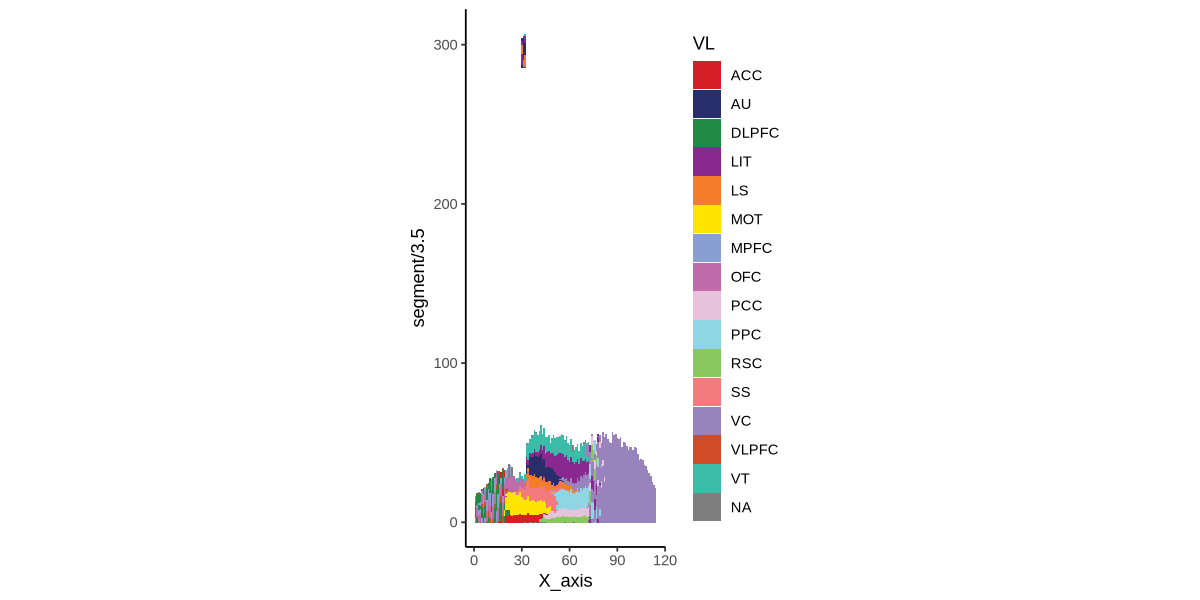

In [102]:
options(repr.plot.width=10,repr.plot.height=5)
ggplot()+
geom_tile(data=segment.meta.data,aes(y=segment/3.5,x=X_axis,fill=VL))+
scale_fill_manual(values = Archr_col)+
theme_classic()+coord_fixed()

In [103]:
library(RANN)
slice_index <- 1:length(unique(segment$slice))
names(slice_index) <- unique(segment$slice)

#find start segment
slice_segment_start <- slice_index
slice_segment_start[slice_index] <- paste0(names(slice_segment_start),'_segment_0')

#registration to frontal
for(i in slice_index['T426']:1){
    forword_slice_id <- slice_segment_start[i+1]
    tmp <- segment[segment$slice==names(slice_index[i]),c('x_registration','y_registration','id')]
    tmp$distance <- nn2(segment[segment$id==forword_slice_id,c('x_registration','y_registration')],
                  tmp[,c('x_registration','y_registration')],k=1)$nn.dists
    close_matrix <- aggregate(list('distance'=tmp$distance),by=list('id'=tmp$id),mean)
    slice_segment_start[i] <- close_matrix[close_matrix$distance==min(close_matrix$distance),]$id    
}
#registration to occipital
for(i in slice_index['T480']:max(slice_index)){
    forword_slice_id <- slice_segment_start[i-1]
    tmp <- segment[segment$slice==names(slice_index[i]),c('x_registration','y_registration','id')]
    tmp$distance <- nn2(segment[segment$id==forword_slice_id,c('x_registration','y_registration')],
                  tmp[,c('x_registration','y_registration')],k=1)$nn.dists
    close_matrix <- aggregate(list('distance'=tmp$distance),by=list('id'=tmp$id),mean)
    slice_segment_start[i] <- close_matrix[close_matrix$distance==min(close_matrix$distance),]$id    
}
slice_segment_start <- as.data.frame(slice_segment_start)
slice_segment_start$segment <- as.numeric(sapply(slice_segment_start$slice_segment_start,function(x){strsplit(x,'_')[[1]][3]}))

In [104]:
#add Y_axis, correct start
segment.meta.data$Y_axis <- 0
for( i in unique(segment.meta.data$slice)){
    tmp_start <- slice_segment_start[i,'segment']
    max_start <- max(segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='No','segment'])
    segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment>=tmp_start&segment.meta.data$pole=='No','Y_axis'] <- segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment>=tmp_start&segment.meta.data$pole=='No','segment'] - tmp_start 
    segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment<tmp_start&segment.meta.data$pole=='No','Y_axis'] <- segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment<tmp_start&segment.meta.data$pole=='No','segment'] + (max_start-tmp_start+1)
    #attach temporal pole to main body 
    if(i%in%c('T439','T438','T437')){
    segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='Yes','segment'] <- segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='Yes','segment'] - min(segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='Yes','segment'])
    tmp_start <- min(segment.meta.data[segment.meta.data$slice==i&segment.meta.data$region=='PaIM','segment'])
    max_start <- max(segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='Yes','segment'])
    segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment>=tmp_start&segment.meta.data$pole=='Yes','Y_axis'] <- segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment>=tmp_start&segment.meta.data$pole=='Yes','segment'] - tmp_start 
    segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment<tmp_start&segment.meta.data$pole=='Yes','Y_axis'] <- segment.meta.data[segment.meta.data$slice==i&segment.meta.data$segment<tmp_start&segment.meta.data$pole=='Yes','segment'] + (max_start-tmp_start+1)
    segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='Yes','Y_axis'] <- segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='Yes','Y_axis'] + max(segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='No'&(!segment.meta.data$region%in%c('Pir','Ent','Apri','A35','A36')),'Y_axis'])
    segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='No'&segment.meta.data$region%in%c('Pir','Ent','Apri','A35','A36'),'Y_axis'] <- segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='No'&segment.meta.data$region%in%c('Pir','Ent','Apri','A35','A36'),'Y_axis'] - min(segment.meta.data[segment.meta.data$slice==i&segment.meta.data$pole=='No'&segment.meta.data$region%in%c('Pir','Ent','Apri','A35','A36'),'Y_axis']) + max(segment.meta.data[segment.meta.data$slice==i,'Y_axis'])
    }
}

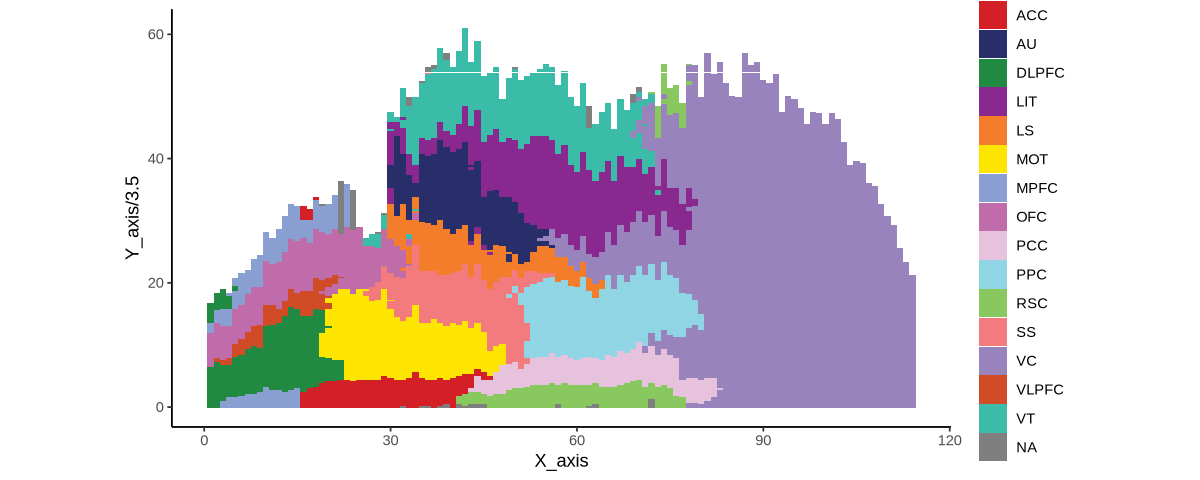

In [105]:
options(repr.plot.width=10,repr.plot.height=4)
ggplot()+
geom_tile(data=segment.meta.data,aes(y=Y_axis/3.5,x=X_axis,fill=VL))+
scale_fill_manual(values = Archr_col)+
theme_classic()+coord_fixed()

In [106]:
#calculate length by segment midpoint
correct_length <- aggregate(list('x'=segment[segment$pole=='No',]$x_registration,'y'=segment[segment$pole=='No',]$y_registration),
                            by=list('id'=segment[segment$pole=='No',]$id,'slice'=segment[segment$pole=='No',]$slice,'segment'=segment[segment$pole=='No',]$segment),
                            mean)
max_segment <- aggregate(list('segment'=segment.meta.data[segment.meta.data$pole=='No',]$segment),
                            by=list('slice'=segment.meta.data[segment.meta.data$pole=='No',]$slice),
                            max)
rownames(max_segment) <- max_segment$slice

slice_list <- 1:length(unique(correct_length$slice))
names(slice_list) <- sort(unique(correct_length$slice))

for( slice in names(slice_list) ){
tmp <- correct_length[correct_length$slice==slice,]
tmp <- tmp[order(tmp$segment,decreasing = F),]
tmp1 <- tmp[1:(nrow(tmp)-1),c('x','y')]
tmp1[,c('x1','y1')] <- tmp[2:nrow(tmp),c('x','y')]
slice_list[slice] <- sum(((tmp1$x-tmp1$x1)**2+(tmp1$y-tmp1$y1)**2)**0.5)
    }

max_segment <- aggregate(list('segment'=segment.meta.data$segment),
                            by=list('slice'=segment.meta.data$slice),
                            max)
rownames(max_segment) <- max_segment$slice

In [107]:
#Adjusted the flatmap Y_axis by real length, and set the length of each segment for visualization
segment.meta.data$real_length <- slice_list[segment.meta.data$slice]
segment.meta.data$max_segment <- max_segment[segment.meta.data$slice,'segment']

segment.meta.data$Y_axis <- (segment.meta.data$Y_axis/segment.meta.data$max_segment)*(segment.meta.data$real_length)/35
segment.meta.data[segment.meta.data$slice%in%c('T408','T409','T410','T411','T441'),'Y_axis'] <- segment.meta.data[segment.meta.data$slice%in%c('T408','T409','T410','T411','T441'),'Y_axis']*1.1

segment.meta.data[segment.meta.data$slice%in%c('T437','T438','T439','T440','T441','T442','T443','T444','T445','T446','T447','T448','T449','T450','T451','T452','T453','T454','T455','T456'),'Y_axis'] <- 
segment.meta.data[segment.meta.data$slice%in%c('T437','T438','T439','T440','T441','T442','T443','T444','T445','T446','T447','T448','T449','T450','T451','T452','T453','T454','T455','T456'),'Y_axis']/1.1

segment.meta.data$length <- ((segment.meta.data$real_length)/35)/segment.meta.data$max_segment
segment.meta.data[segment.meta.data$slice%in%c('T437','T438','T439','T440','T441','T442','T443','T444','T445','T446','T447','T448','T449','T450','T451','T452','T453','T454','T455','T456'),'length'] <- 
segment.meta.data[segment.meta.data$slice%in%c('T437','T438','T439','T440','T441','T442','T443','T444','T445','T446','T447','T448','T449','T450','T451','T452','T453','T454','T455','T456'),'length']/1.1

segment.meta.data[segment.meta.data$slice%in%c('T408','T409','T410','T411','T441'),'length'] <- 
segment.meta.data[segment.meta.data$slice%in%c('T408','T409','T410','T411','T441'),'length']*1.1

segment.meta.data$length <- segment.meta.data$length+0.1

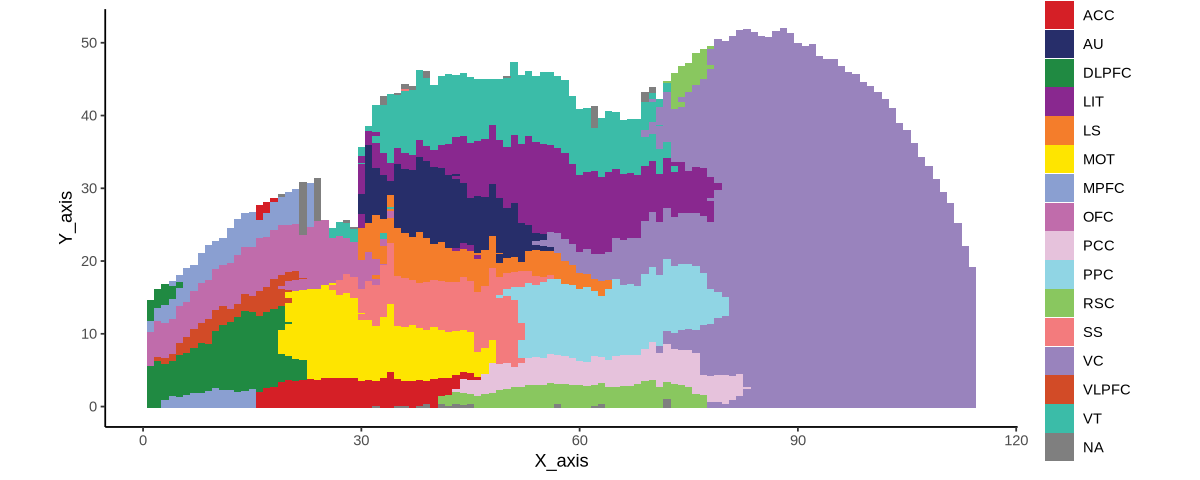

In [108]:
options(repr.plot.width=10,repr.plot.height=4)
ggplot()+
geom_tile(data=segment.meta.data,aes(y=Y_axis,x=X_axis,fill=VL,height=length))+
scale_fill_manual(values = Archr_col)+
theme_classic()+coord_fixed()

In [109]:
#imputation the NA value by winner_kNN
segment.meta.data$region_imputation <- segment.meta.data$region
segment.meta.data$Y_axis_smooth <- segment.meta.data$Y_axis*3.5
segment.meta.data[segment.meta.data$region_imputation=='NULL','region_imputation'] <- winner_kNN(
                                            segment.meta.data[segment.meta.data$region!='NULL',c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$region=='NULL',c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$region!='NULL','region_imputation'], 
                                            knn=5,threhold=1
                                           )
#Convert marmoset region to large lobe, data from TableS1
marmoset2VL <- read.csv('Tabledata/marmoset2VL.txt',sep='\t',header=T)
rownames(marmoset2VL) <- marmoset2VL$Abbre
segment.meta.data$VL_imputation <- marmoset2VL[segment.meta.data$region_imputation,'Lobe.abbre']

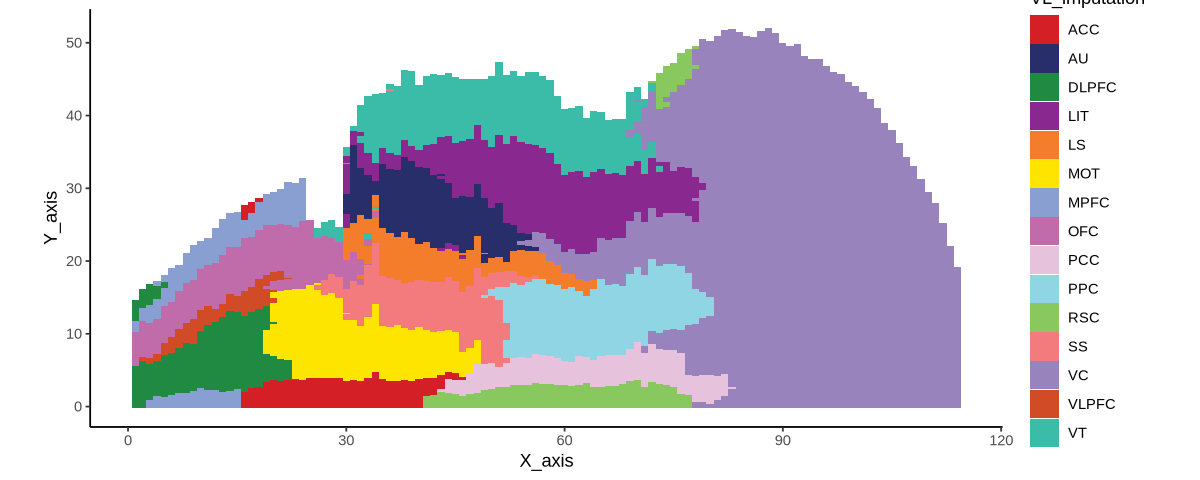

In [110]:
options(repr.plot.width=10,repr.plot.height=4)
ggplot()+
geom_tile(data=segment.meta.data,aes(y=Y_axis,x=X_axis,fill=VL_imputation,height=length))+
scale_fill_manual(values = Archr_col)+
theme_classic()+coord_fixed()

In [111]:
#smooth the VL by winner_kNN
segment.meta.data$VL_smooth <- segment.meta.data$VL_imputation
for(i in 1:2){
segment.meta.data$VL_smooth <- winner_kNN(
                                            segment.meta.data[,c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[,c('Y_axis_smooth','X_axis')],
                                            segment.meta.data$VL_smooth, 
                                            knn=9,threhold=2
                                           )}

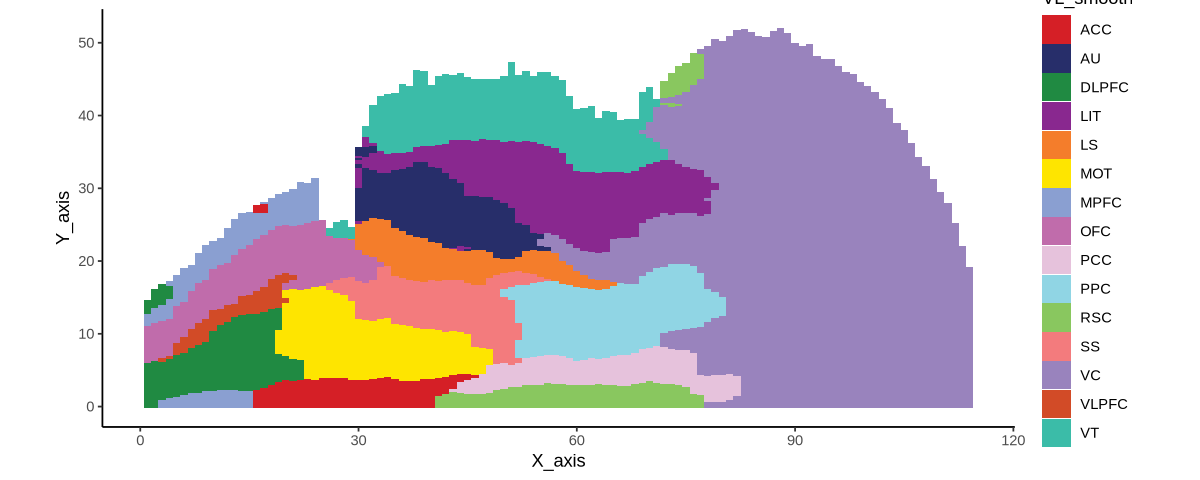

In [112]:
options(repr.plot.width=10,repr.plot.height=4)
ggplot()+
geom_tile(data=segment.meta.data,aes(y=Y_axis,x=X_axis,fill=VL_smooth,height=length))+
scale_fill_manual(values = Archr_col)+
theme_classic()+coord_fixed()

In [113]:
#adjust the VL_smooth by manual
segment.meta.data[segment.meta.data$VL_smooth%in%c('DLPFC','MPFC'),]$VL_smooth <- winner_kNN(
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('DLPFC','MPFC'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('DLPFC','MPFC'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('DLPFC','MPFC'),'VL_smooth'], 
                                            knn=15)
segment.meta.data[segment.meta.data$VL_smooth%in%c('ACC','MPFC'),]$VL_smooth <- winner_kNN(
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('ACC','MPFC'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('ACC','MPFC'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('ACC','MPFC'),'VL_smooth'], 
                                            knn=20)
segment.meta.data[segment.meta.data$VL_smooth%in%c('VC','RSC'),]$VL_smooth <- winner_kNN(
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('VC','RSC'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('VC','RSC'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('VC','RSC'),'VL_smooth'], 
                                            knn=20)
segment.meta.data[segment.meta.data$VL_smooth%in%c('AU','LIT'),]$VL_smooth <- winner_kNN(
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('AU','LIT'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('AU','LIT'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('AU','LIT'),'VL_smooth'], 
                                            knn=15)
segment.meta.data[segment.meta.data$VL_smooth%in%c('AU')&segment.meta.data$Y_axis>33.5,]$VL_smooth <- 'LIT'
segment.meta.data[segment.meta.data$VL_smooth%in%c('VT','LIT'),]$VL_smooth <- winner_kNN(
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('VT','LIT'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('VT','LIT'),c('Y_axis_smooth','X_axis')],
                                            segment.meta.data[segment.meta.data$VL_smooth%in%c('VT','LIT'),'VL_smooth'], 
                                            knn=15)
segment.meta.data[segment.meta.data$VL_smooth%in%c('DLPFC')&segment.meta.data$Y_axis>10&segment.meta.data$X_axis<8,]$VL_smooth <- 'MPFC'
segment.meta.data[segment.meta.data$VL_smooth%in%c('VT')&segment.meta.data$Y_axis<30,]$VL_smooth <- 'OFC'

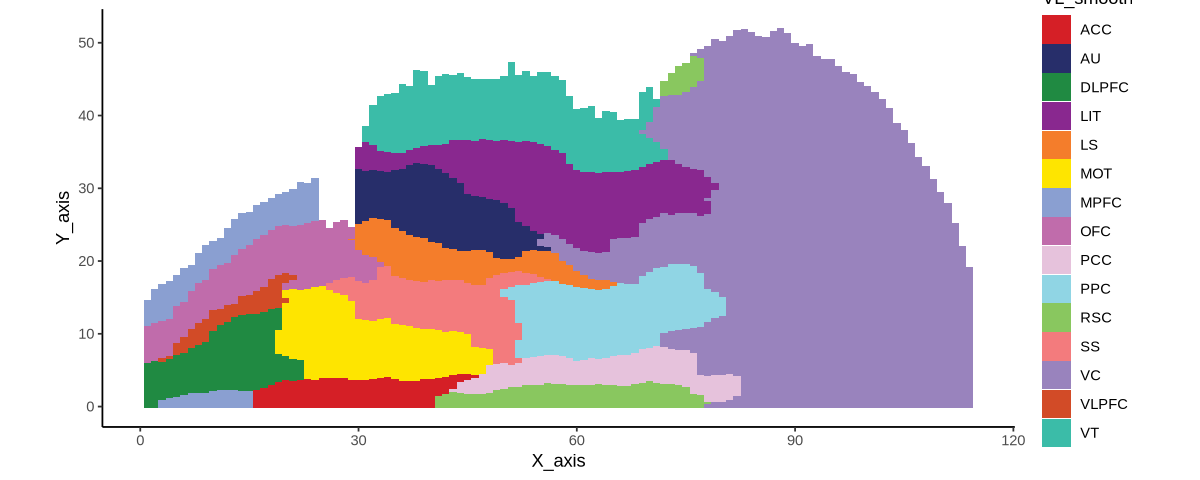

In [114]:
options(repr.plot.width=10,repr.plot.height=4)
ggplot()+
geom_tile(data=segment.meta.data,aes(y=Y_axis,x=X_axis,fill=VL_smooth,height=length))+
scale_fill_manual(values = Archr_col)+
theme_classic()+coord_fixed()

In [146]:
#VL border, download from https://db.cngb.org/stomics/mbcsta/download/
Border <- read.csv('data/Border.txt')

In [147]:
source('R_function/segment_plot.R')

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


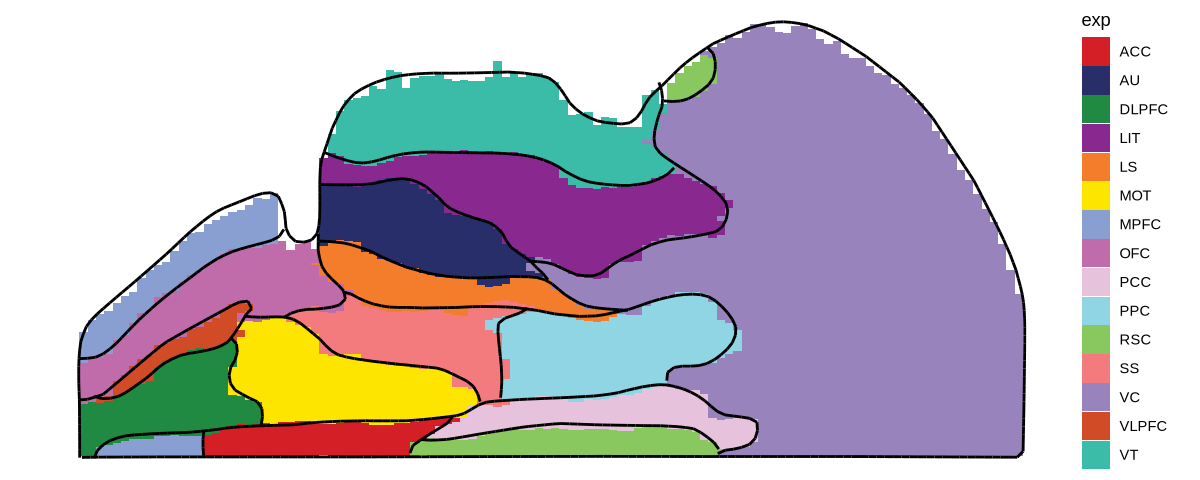

In [149]:
options(repr.plot.width=10,repr.plot.height=4)
#plot segment metadata and add VL border
plot_col_exp(segment.meta.data,col_exp = 'VL_smooth',border = T)+scale_fill_manual(values = Archr_col)

<font size=10>---------------Combined cell data-------------<font size=10>

In [118]:
library(Seurat)

In [122]:
#Stereo cell annotation data, download from https://db.cngb.org/stomics/mbcsta/download/
celldata <- readRDS('data/marmoset.rds')
celldata_NN <- readRDS('data/marmoset_Non_Neuron.rds')
celldata <- rbind(celldata,celldata_NN)

#Merge segment mask to celldata
cell_data$label <- paste0(cell_data$slice,'_',round(cell_data$x/50),'_',round(cell_data$y/50))
cell_data$segment <- NA
for(slice in unique(segment$slice)){
    tmp <- segment[segment$slice==slice,]
    cell_data[cell_data$slice==slice,'segment'] <- tmp[cell_data[cell_data$slice==slice,]$label,'segment']
    }
cell_data_segment <- cell_data[!is.na(cell_data$segment),]

In [186]:
saveRDS(cell_data_segment,'data/bin50_segment_cell_data.rds')

In [150]:
library(Seurat)
library(Matrix)
#Create celltype × segment, seurat object
obj_segment <- creat_segment_obj(cell_data_segment,cluster1 = c('Gaba','Glut'))
obj_segment <- prepare_obj(obj_segment)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [143]:
nrow(segment.meta.data)
obj_segment

[1] 17525

An object of class Seurat 
181 features across 17386 samples within 1 assay 
Active assay: RNA (181 features, 181 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

In [163]:
#imputation obj_segment to 17525 segments from segment2flatmap.R
source('R_function/segment2flatmap.R')
obj_segment_imputation <- imputation_celltype(obj_segment,segment.meta.data)

In [164]:
obj_segment_imputation

An object of class Seurat 
181 features across 17525 samples within 1 assay 
Active assay: RNA (181 features, 181 variable features)
 2 layers present: counts, data

In [166]:
source('R_function/segment_plot.R')

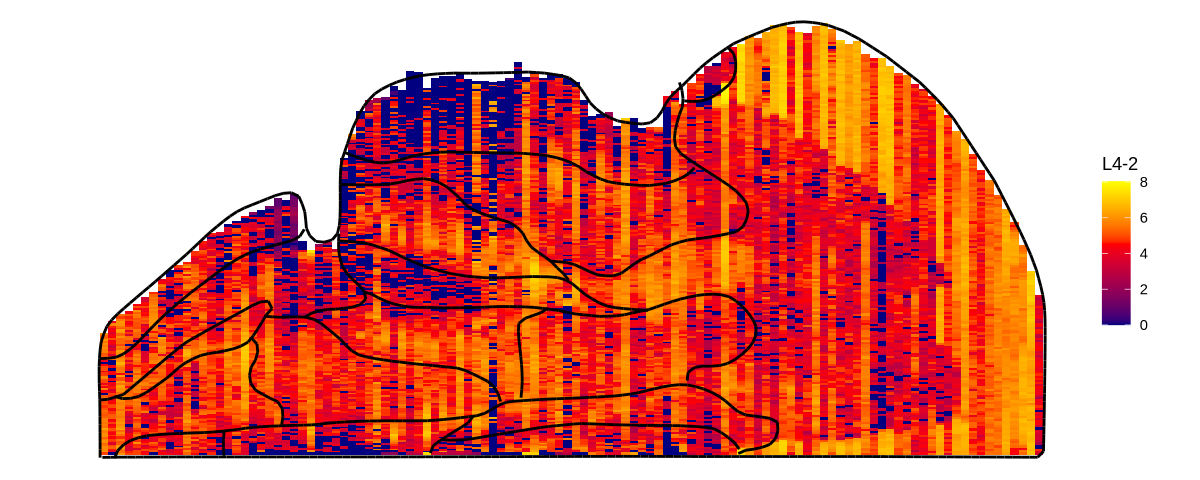

In [167]:
#plot cell type distribution use plot_feature function from segment_plot.R
plot_features(obj_segment_imputation,features = c('L4-2'),assays='RNA',slot='data')

In [168]:
source('R_function/segment2flatmap.R')

In [169]:
#smooth cell type distribution by X_axis and Y_axis_smooth from segment2flatmap.R
obj_segment_smooth <- smooth_celltype(obj_segment_imputation)

Warning message:
“Cannot add objects with duplicate keys (offending key: rna_), setting key to 'smooth_'”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Centering and scaling data matrix



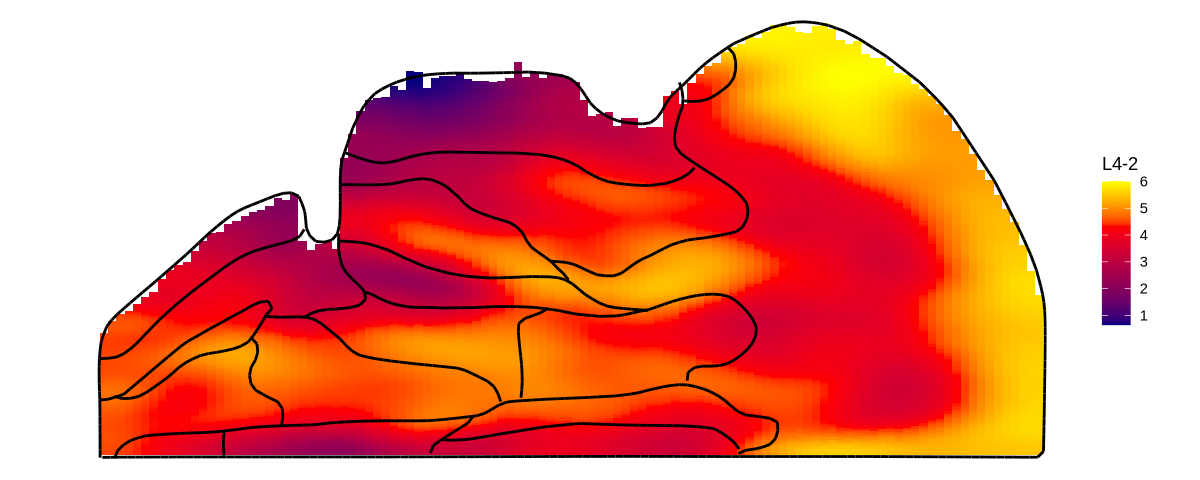

In [171]:
#plot cell type distribution use plot_feature function from segment_plot.R
plot_features(obj_segment_smooth,features = c('L4-2'),assays='smooth',slot='data')

In [ ]:
#The processed file can be downloaded at https://db.cngb.org/stomics/mbcsta/download/
saveRDS(obj_segment_smooth,'data/Segment_celltypes_marmoset.rds')